In [226]:
import pandas as pd
import sqlite3
import matplotlib.pyplot as plt
import matplotlib.pyplot as plt
%matplotlib inline
plt.rcParams["figure.figsize"] = [20,12]
plt.style.use('fivethirtyeight')

pd.set_option('display.max_columns', 100)
pd.set_option('display.max_rows', 1000)

In [227]:
"""
# Connecting to SQLite Database
conn = sqlite3.connect('lahman2016.sqlite')

# Querying Database for all seasons where a team played 150 or more games and is still active today. 
query = '''select * from playerID 
inner join TeamsFranchises
on Teams.franchID == TeamsFranchises.franchID
where Teams.G >= 150 and TeamsFranchises.active == 'Y';
'''

# Creating dataframe from query.
Teams = conn.execute(query).fetchall()"""

"\n# Connecting to SQLite Database\nconn = sqlite3.connect('lahman2016.sqlite')\n\n# Querying Database for all seasons where a team played 150 or more games and is still active today. \nquery = '''select * from playerID \ninner join TeamsFranchises\non Teams.franchID == TeamsFranchises.franchID\nwhere Teams.G >= 150 and TeamsFranchises.active == 'Y';\n'''\n\n# Creating dataframe from query.\nTeams = conn.execute(query).fetchall()"

# Importing baseball data

In [228]:
df = pd.read_csv('Data\core\Batting.csv')

# Cleaning data and building dataframe

In [229]:
#getting rid of rows with no at bats
df = df[df['AB']>0]

In [230]:
#filtering out pitchers
list_pitcher_IDs = list(pd.read_csv('Data\core\Pitching.csv')['playerID'].drop_duplicates())

df = df[~df['playerID'].isin(list_pitcher_IDs)]

In [231]:
#adding player names
df_player_names = pd.read_csv('Data\core\Master.csv')[['playerID', 'nameFirst', 'nameLast']].drop_duplicates()

dict_player_names = {df_player_names.iloc[i]['playerID']:
                     str(df_player_names.iloc[i]['nameFirst'])+' '+str(df_player_names.iloc[i]['nameLast']) for i in 
                     range(len(df_player_names))}

#removing blank names
for playerID in dict_player_names.keys():
    if dict_player_names[playerID].split(' ')[0]=='nan':
        dict_player_names[playerID] = dict_player_names[playerID].split(' ')[1]

In [232]:
df['Name'] = df['playerID'].map(lambda x: dict_player_names[x])

In [233]:
df_BA = df.groupby(['playerID', 'Name'], as_index=False)[['AB','H']].sum()
df_BA['average'] = 0.000

#working around nan error with pandas divide
for row in df_BA.index:
    H = df_BA.loc[row]['H']
    AB = df_BA.loc[row]['AB']
    val = float(H)/float(AB)
    df_BA = df_BA.set_value(row, 'average', val)

In [234]:
#filtering out players with less than 500 hits to remove noise

df_BA = df_BA[df_BA['H']>500]

# Fitting the Beta Distribution

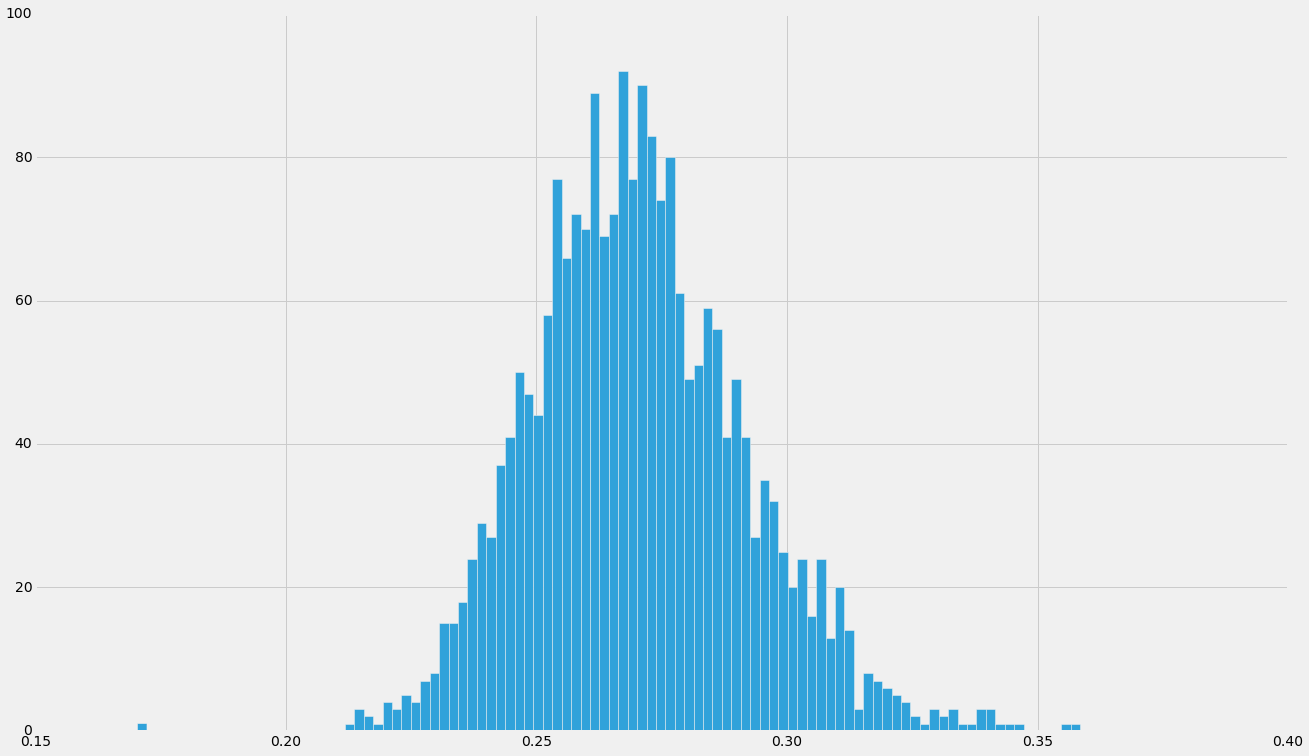

In [235]:
df_BA['average'].hist(bins=100)

In [236]:
from scipy.stats import beta

In [237]:
mu = df_BA['average'].mean()
sigma = df_BA['average'].std()

a = (mu**2)*(((1-mu)/(sigma**2))-(1/mu))
b = a*((1/mu)-1)

In [238]:
a, b

(117.98357784382168, 318.54678927619267)

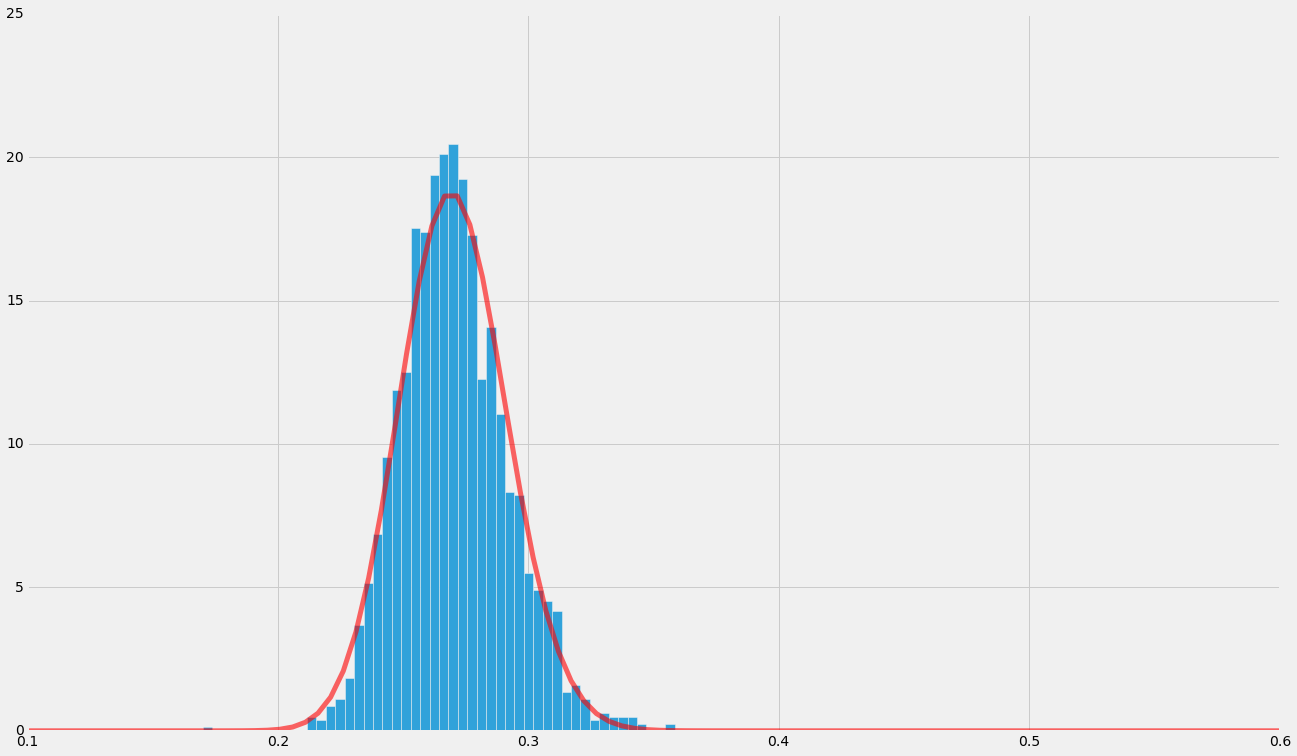

In [244]:
x = np.linspace(0.1,0.6,100)
plt.plot(x, beta.pdf(x, a, b),'r-', lw=5, alpha=0.6, label='beta pdf')
plt.hist(df_BA['average'], normed = True, bins = 50)
plt.show()

# Using the Beta distribution to estimate the batting average at the start of the season

If a player has had 1000 at bats and 300 hits, we'll estimate his batting average as...

# $\frac{300+\alpha}{1000+\alpha+\beta}$

In [245]:
print((300+a)/(1000+a+b))

0.290967450052


If a player has had 10 at bats and 4 hits, we'll estimate his batting average as...

# $\frac{4+\alpha}{10+\alpha+\beta}$

In [247]:
print((4+a)/(10+a+b))

0.273180923014


**Calculating the empirical Bayes approximation for all batters** 

In [250]:
df_BA['Empirical Bayes Estimate'] = df_BA.apply(lambda x: (x['H']+a)/(x['AB']+a+b), axis=1)

In [253]:
df_BA.to_csv('df_BA.csv')